In [44]:
%matplotlib inline
import importlib
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras_tqdm import TQDMNotebookCallback
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import keras
from keras.layers import *
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import model_to_dot

plt.style.use('seaborn')

In [2]:
# Import user-item rating dataframe
ratings = pd.read_json('ratings_reduced.json')
ratings.head()

,gameid,user,score
0,174430,pinbot,9.0
1000,174430,igomin,10.0
10000000,63632,ProEvo,7.0
10000001,63632,Scrabbler,7.0
10000002,63632,didier_adasoc,5.0


In [3]:
# Convert user names and game IDs to matrix indices
userdict = {}
for i, user in enumerate(ratings.user.unique()):
    userdict[user] = i
    
gamedict = {}
for i, game in enumerate(ratings.gameid.unique()):
    gamedict[game] = i
    
ratings['user'] = ratings['user'].map(userdict.get)
ratings['gameid'] = ratings['gameid'].map(gamedict.get)
ratings = ratings[['user', 'gameid', 'score']]
ratings.head()

,user,gameid,score
0,0,0,9.0
1000,1,0,10.0
10000000,2,1,7.0
10000001,3,1,7.0
10000002,4,1,5.0


In [4]:
# Split data in testing and training sets
X = ratings[['gameid','user']]
y = ratings['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=29, stratify=X['gameid'])

In [5]:
# Build a user-item score matrices for training and testing
x_train = scipy.sparse.coo_matrix((y_train, (X_train['user'],X_train['gameid'])))
x_train = x_train.todense().astype('float32')
x_test = scipy.sparse.coo_matrix((y_test, (X_test['user'],X_test['gameid'])))
x_test = x_test.todense().astype('float32')

In [12]:
def subtract_user_mean(x_train, x_test):
    """This function subtracts out each user's mean rating from their individual ratings"""
    trainset = pd.DataFrame(x_train)
    testset = pd.DataFrame(x_test)
    
    trainset[trainset == 0] = np.nan
    testset[testset == 0] = np.nan
    
    user_means = trainset.mean(axis=1)
    trainset = trainset.subtract(user_means, axis=0)
    testset = testset.subtract(user_means, axis=0)
    
    trainset = trainset.fillna(0)
    testset = testset.fillna(0)
    return trainset.values, testset.values, user_means

In [6]:
def remove_biases(x_train, x_test):
    trainset = pd.DataFrame(x_train)
    testset = pd.DataFrame(x_test)
    
    trainset[trainset == 0] = np.nan
    testset[testset == 0] = np.nan
    
    global_mean = np.nanmean(trainset.values)
    trainset = (trainset-global_mean)
    testset = (testset-global_mean)
    
    item_means = trainset.mean()
    user_means = trainset.mean(axis=1)
    trainset = trainset - item_means
    trainset = trainset.subtract(user_means, axis=0)
    testset = testset - item_means
    testset = testset.subtract(user_means, axis=0)
    
    trainset = trainset.fillna(0)
    testset = testset.fillna(0)
    return trainset.values, testset.values, global_mean, item_means, user_means

$$r'_{ui} = r_{ui} - \mu - b_i - b_u$$
$$b_i = \overline{r}_i - \mu$$
$$b_u = \overline{r}_u - \mu$$

In [9]:
def replace_biases(ratings, global_mean, user_means, item_means):
    rate = pd.DataFrame(ratings)
    rate = (rate + global_mean)
    rate = rate + item_means
    rate = rate.add(user_means, axis=0)
    rate = rate.values
    rate[rate>10] = 10
    rate[rate<1] = 1
    return rate

In [7]:
x_train, x_test, global_mean, user_means, item_means = remove_biases(x_train, x_test)

In [8]:
x_full = x_train + x_test

In [9]:
def masked_rmse(mask_value):
    def f(y_true, y_pred):
        mask_true = K.cast(K.not_equal(y_true, mask_value), K.floatx())
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        if (K.sum(mask_true, axis=-1)==0):
            masked_rmse = 0
        else:
            masked_rmse = (K.sum(masked_squared_error, axis=-1)/(K.sum(mask_true, axis=-1)))**0.5
        return masked_rmse
    return f

In [10]:
n_input = x_train.shape[1]

inputs = Input(shape=(n_input,))
drop = Dropout(0.8)(inputs)
encode = Dense(32, activation='selu')(drop)
encode = Dense(32, activation='selu')(encode)
latent = Dense(32, activation='selu')(encode)
decode = Dense(32, activation='selu')(latent)
decode = Dense(32, activation='selu')(decode)
outputs = Dense(n_input, activation='linear')(decode)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss = masked_rmse(0))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4905)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4905)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                156992    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)      

In [56]:
n_input = x_train.shape[1]

inputs = Input(shape=(n_input,))
drop = Dropout(0.8)(inputs)
encode = Dense(32, activation='selu')(drop)
encode = Dense(32, activation='selu')(encode)
encode = Dense(8, activation='selu')(encode)
encode = Dense(32, activation='selu')(encode)
encode = Dense(32, activation='selu')(encode)
outputs = Dense(n_input, activation='linear')(encode)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss = masked_rmse(0))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 4905)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 4905)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 32)                156992    
_________________________________________________________________
dense_34 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_35 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_36 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_37 (Dense)             (None, 32)                1056      
__________

In [57]:
params = {'verbose': 0, 'callbacks': [EarlyStopping(patience=2, restore_best_weights=True), TQDMNotebookCallback(leave_inner=True)]}
history = model.fit(x_train, x_train, validation_data=(x_train, x_test), epochs=30, batch_size=128, **params)

In [38]:
n = [8, 16, 32, 64]
train_loss = []
val_loss = []
for i in n:
    n_input = x_train.shape[1]
    inputs = Input(shape=(n_input,))
    encode = Dense(i, activation='selu')(inputs)
    encode = Dense(i, activation='selu')(encode)
    encode = Dense(i, activation='selu')(encode)
    encode = Dense(i, activation='selu')(encode)
    encode = Dense(i, activation='selu')(encode)
    outputs = Dense(n_input, activation='linear')(encode)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss = masked_rmse(0))
    params = {'verbose': 0, 'callbacks': [EarlyStopping(patience=1, restore_best_weights=True), TQDMNotebookCallback(leave_inner=True)]}
    history = model.fit(x_train, x_train, validation_data=(x_train, x_test), epochs=30, batch_size=128, **params)
    train_loss.append(np.min(history.history['loss']))
    val_loss.append(np.min(history.history['val_loss']))




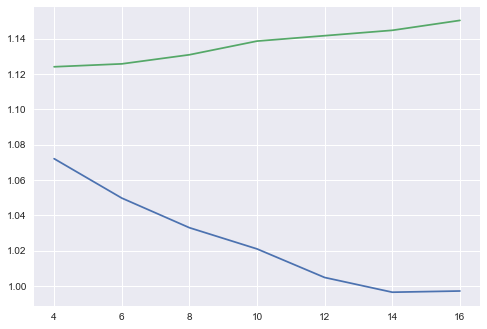

In [36]:
plt.plot(n, train_loss)
plt.plot(n, val_loss)

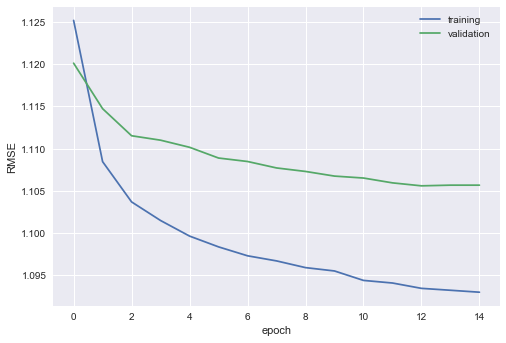

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend(['training', 'validation'])
plt.show()

In [59]:
np.min(history.history['val_loss'])

1.1055975374713927

In [14]:
# Import game database file in order to parse game IDs back to the game names
infodf = pd.read_json('bgg_database.json')
infodf.index.name = 'gameid'
infodf = infodf.reset_index()
del infodf['ratings']
infodf.head()

,gameid,last_updated,player_count,num_voters,name,weight,rank,average_rating,year,families,play_time,attributes,weighted_rating,description
0,1,Tue Mar 19 03:05:58 2019,"{'1': {'Recommended': '1', 'Not Recommended': ...",4762,Die Macher,4.3443,218,7.63445,1986,[strategygames],240,"{'boardgamedesigner': 'Karl-Heinz Schmiel', 'b...",7.19502,Die Macher is a game about seven sequential po...
1,10,Tue Mar 19 02:27:37 2019,"{'6+': {'Recommended': '1', 'Not Recommended':...",7353,Elfenland,2.1625,862,6.73148,1998,[familygames],60,"{'boardgamedesigner': 'Alan R. Moon', 'boardga...",6.53778,Elfenland is a redesign of the original White ...
2,100169,Tue Mar 19 05:07:46 2019,"{'1': {'Recommended': '1', 'Not Recommended': ...",148,Hero of Weehawken,2.1579,3991,7.58219,2011,[thematic],45,"{'boardgamedesigner': 'Robert Leonhard', 'boar...",5.72384,Historic Gaming #7&#10;&#10;Hero of Weehawken ...
3,1002,Tue Mar 19 04:55:28 2019,"{'1': {'Recommended': '0', 'Not Recommended': ...",444,Cosmic Eidex,2.6786,2820,6.90013,1998,[strategygames],60,"{'boardgamedesigner': 'Urs Hostettler', 'board...",5.87115,Cosmic Eidex is an intriguing little trick-tak...
4,100423,Tue Mar 19 00:08:24 2019,"{'8+': {'Recommended': '1', 'Not Recommended':...",19106,Elder Sign,2.3571,491,7.00700,2011,[thematic],90,"{'boardgamedesigner': 'Kevin Wilson', 'boardga...",6.85712,Game description from the publisher:&#10;&#10;...


In [60]:
pred_full = model.predict(x_full)

In [61]:
pred_full[x_full==0] = 0
err_w_nan = pred_full-x_full
err_w_nan[err_w_nan==0] = np.nan
sq_err = np.square(err_w_nan)
root_mean_sq_err = np.sqrt(np.nanmean(sq_err, axis=0))
mean_err = np.array([root_mean_sq_err])
pred_std = np.array([np.nanstd(err_w_nan, axis=0)])

In [62]:
user = 'spleenmuncher'

In [63]:
rating_input = x_full[userdict[user],:].reshape(1,4905).copy()

In [64]:
my_ratings = rating_input.copy()
my_ratings[my_ratings!=0] = my_ratings[my_ratings!=0] + np.array([user_means])[my_ratings!=0] + np.array(item_means)[userdict[user]] + global_mean

In [65]:
my_pred = model.predict(rating_input)

In [66]:
my_pred = my_pred + np.array(user_means) + np.array(item_means)[userdict[user]] + global_mean

In [67]:
gamedf = pd.DataFrame.from_dict(gamedict, orient='index').reset_index()
gamedf.columns = ['gameid','mat_idx']
gamedf['my_pred'] = my_pred[0]
gamedf['my_rating'] = my_ratings[0]
gamedf.head()

,gameid,mat_idx,my_pred,my_rating
0,174430,0,8.790935,0.0
1,63632,1,6.287340,0.0
2,68448,2,7.169964,6.0
3,167791,3,8.104713,7.0
4,178302,4,7.538388,0.0


In [68]:
gamedf = gamedf.merge(infodf, how='left', left_on='gameid', right_on='gameid')[['gameid', 'name', 'my_pred', 'my_rating', 'average_rating', 'num_voters']]

In [71]:
gamedf['popularity'] = gamedf['num_voters'].rank(ascending=False)
gamedf.head()

,gameid,name,my_pred,my_rating,average_rating,num_voters,std,RMSE,popularity
0,174430,Gloomhaven,8.790935,0.0,8.91228,23504,1.433502,1.435282,60.0
1,63632,Jerusalem,6.287340,0.0,6.74812,709,1.028262,1.031527,2520.0
2,68448,7 Wonders,7.169964,6.0,7.78490,67739,1.052449,1.052545,4.0
3,167791,Terraforming Mars,8.104713,7.0,8.40232,36736,1.176985,1.177093,23.0
4,178302,Welcome to Centerville,7.538388,0.0,7.06078,463,1.114885,1.114885,3232.0


In [73]:
gamedf['std'] = pred_std.T
gamedf['RMSE'] = mean_err.T
gamedf = gamedf.sort_values('my_pred', ascending=False)

In [80]:
gamedf.head(10)[['gameid', 'name', 'my_pred', 'average_rating', 'num_voters', 'popularity']]

,gameid,name,my_pred,average_rating,num_voters,popularity
3240,235802,Too Many Bones: Undertow,9.314951,8.96092,631,2718.5
4640,242722,Here I Stand (500th Anniversary Reprint Edition),9.118732,8.69876,225,4417.0
351,7935,1844: Switzerland,9.106171,8.33923,180,4686.0
39,32989,Axis Empires: Totaler Krieg!,9.041317,8.37052,229,4392.5
227,193867,1822: The Railways of Great Britain,9.002617,8.50138,182,4669.0
2621,224517,Brass: Birmingham,8.982116,8.63405,4815,516.0
4370,68820,Enemy Action: Ardennes,8.963823,8.67158,297,3973.5
4302,63170,1817,8.911486,8.73544,268,4154.5
2449,220308,Gaia Project,8.909788,8.56949,8593,273.0
609,108018,Riichi Mahjong,8.837430,8.43058,188,4632.5


In [81]:
owned_filter = gamedf.my_rating!=0
popularity_max = len(gamedf[owned_filter])*10
popularity_filter = gamedf.popularity <= popularity_max
gamedf.sort_values('my_pred', ascending=False)[popularity_filter].head(10)[['gameid', 'name', 'my_pred', 'average_rating', 'num_voters', 'popularity']]

c:\users\aaron\miniconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,gameid,name,my_pred,average_rating,num_voters,popularity
2621,224517,Brass: Birmingham,8.982116,8.63405,4815,516.0
2449,220308,Gaia Project,8.909788,8.56949,8593,273.0
0,174430,Gloomhaven,8.790935,8.91228,23504,60.0
2529,175640,Vinhos Deluxe Edition,8.729107,8.24893,2519,956.5
3067,175914,Food Chain Magnate,8.683999,8.18605,9311,256.0
2601,162886,Spirit Island,8.651888,8.38891,9757,233.0
2457,161533,Lisboa,8.616892,8.19692,3845,640.0
2474,193738,Great Western Trail,8.603271,8.28808,18302,95.0
2770,28720,Brass: Lancashire,8.526196,8.11884,14647,140.0
2578,19777,Indonesia,8.498173,7.83536,3486,714.0
